### МОДЕЛИРОВАНИЕ КРАТКОСРОЧНОЙ КРИВОЙ ФИЛЛИПСА НА РЕГИОНАЛЬНЫХ ДАННЫХ РОССИИ

Кривая Филлипса — кривая, иллюстрирующая обратную зависимость между уровнем инфляции и уровнем безработицы.

В работе при помощи МНК оцениваются гибридная модель, а также ее частные случаи: адаптивная и неокейнсианская 
модели. Результаты показывают, что из трех рассмотренных модификаци 
фактический ряд данных наиболее точно описывается гибридной модель ,
включающей разрыв выпуска и учитывающей оба типа ожиданий экономических агентов: впередсмотрящие и назадсмотрящие. 

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import seaborn as sns
import statsmodels.stats.api as sms

В работе используются данные за 2019 год. Рассматривается 80 регионов.
Из данных были удалены выбросы по безработице и инфляции для корректной работы модели. 

Для предсказания инфляции объясняющими переменными являются стандартные для кривой Филлипса:
1. разрыв выпуска (в качестве аппроксимации разрыва регионального выпуска используется темп прироста ВРП) 
2. уровень естественной безработицы
3. инфляция прошлого года
4. ожидаемая инфляция (впередсмотрящие инфляционные ожидания аппроксимируются фактической инфляцией в следующий момент времени. Таким образом, предполагается, что рациональная часть экономических агентов формирует их в соответствии с гипотезой совершенного предвидения)
   
а также нестандартные переменные:
1. темп прироста доходов (зависимость в первоначальной модели Филлипса показывала связь безработицы с изменениями зарплат)
2. индекс промышленного производства (индекс важен, потому что отражает данные о занятости и доходах рабочих, и может косвенно говорить о деловой активности, может быть как краткосрочный индикатор экономического цикла для определения фазы (рост/подъем или спад))
3. показатель региональной фискальной политики (аппроксимируется долей расходов консолидированного регионального бюджета в ВРП)

In [5]:
data = pd.read_excel("regions.xlsx")
data.head()

,Области,CPA_20,CPA_19,CPA_18,Inf_20,Inf_19,Inf_18,Unemployment,GRP_19,GRP_18,GRP_Growth,Income_19,Income_growth,Ind_Production,Ind_Production_growth,Import_far,Import_CIS,NEER,G_EXP
0,Белгородская область,104.9,102.8,104.4,4.9,2.8,4.4,3.9,955951.6,911597.9,4.865489,100.6,0.6,103.6,3.6,706.9,780.5,1487.4,"124 172,5"
1,Брянская область,105.2,103.6,104.9,5.2,3.6,4.9,3.8,397714.3,367157.1,8.322650,100.5,0.5,118.4,18.4,415.1,468.6,883.7,"73 285,4"
2,Владимирская область,105.6,102.2,105.2,5.6,2.2,5.2,4.0,537434.6,480027.8,11.959057,101.9,1.9,111.3,11.3,1378.2,118.5,1496.7,"77 963,4"
3,Воронежская область,106.9,102.6,104.6,6.9,2.6,4.6,3.6,1002597.7,951292.3,5.393232,101.1,1.1,111.5,11.5,653.3,253.2,906.5,"140 467,6"
4,Ивановская область,105.8,102.9,105.1,5.8,2.9,5.1,3.8,249755.8,232493.6,7.424807,99.5,-0.5,102.8,2.8,273.9,265.6,539.5,"49 764,5"


In [6]:
data['G_EXP'] = data['G_EXP'].str.replace('\xa0', '').str.replace(',', '.')
data['G_EXP'] = data['G_EXP'].astype(float)

In [7]:
# удаляем выбросы
data=data[data.Inf_19>data.Inf_19.quantile(0.01)]
data=data[data.Inf_19<data.Inf_19.quantile(0.99)]
data=data[data.Unemployment<data.Unemployment.quantile(0.99)]

In [8]:
data.describe()

,CPA_20,CPA_19,CPA_18,Inf_20,Inf_19,Inf_18,Unemployment,GRP_19,GRP_18,GRP_Growth,Income_19,Income_growth,Ind_Production,Ind_Production_growth,Import_far,Import_CIS,NEER,G_EXP
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,7.700000e+01,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,105.206494,103.037662,104.340260,5.206494,3.037662,4.340260,5.550649,9.009690e+05,8.581459e+05,6.133056,100.915584,0.915584,105.128571,5.128571,1255.105195,218.977922,1474.083117,123448.942857
std,0.816175,0.610875,0.706597,0.816175,0.610875,0.706597,2.376343,1.227886e+06,1.191324e+06,4.537102,1.505260,1.505260,8.267579,8.267579,3065.390769,422.239038,3396.557958,111950.432358
min,101.900000,102.000000,102.400000,1.900000,2.000000,2.400000,2.700000,5.657050e+04,5.406940e+04,-12.318887,97.100000,-2.900000,95.300000,-4.700000,0.000000,0.100000,0.700000,15110.100000
25%,104.900000,102.600000,103.900000,4.900000,2.600000,3.900000,3.900000,2.735435e+05,2.585786e+05,3.987621,99.900000,-0.100000,101.800000,1.800000,142.600000,10.900000,174.000000,54330.500000
50%,105.200000,102.900000,104.400000,5.200000,2.900000,4.400000,4.800000,5.703800e+05,5.210515e+05,5.859046,100.900000,0.900000,103.600000,3.600000,376.500000,69.500000,539.500000,94216.500000
75%,105.700000,103.500000,104.900000,5.700000,3.500000,4.900000,6.100000,1.066725e+06,9.654852e+05,8.263547,101.900000,1.900000,106.800000,6.800000,949.600000,253.200000,1227.400000,160717.800000
max,107.300000,104.700000,106.000000,7.300000,4.700000,6.000000,13.500000,8.919089e+06,8.875004e+06,21.097167,105.600000,5.600000,164.400000,64.400000,24606.200000,2931.800000,27538.000000,813727.100000


Посмотрим как инфляция зависит от различных факторов

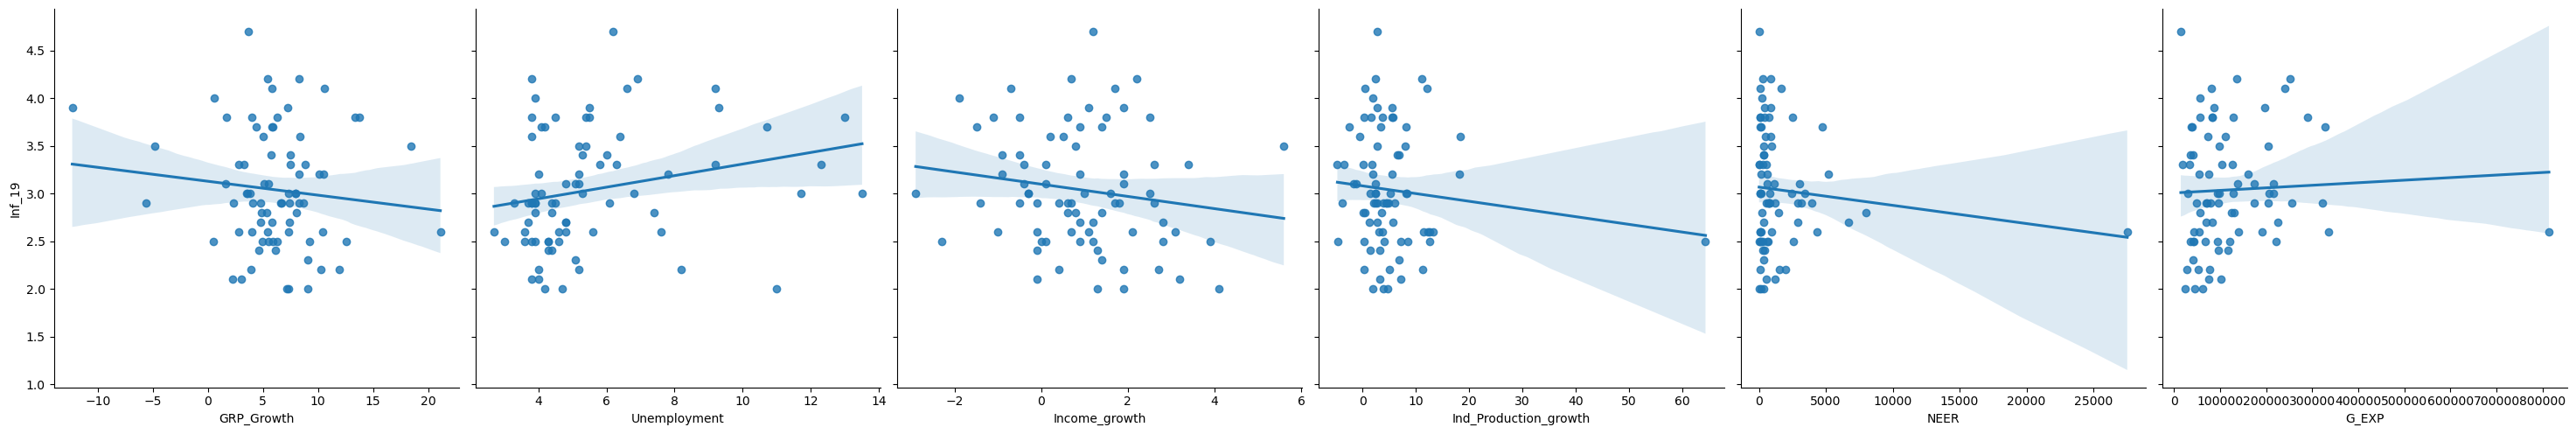

In [10]:
sns.pairplot(data, y_vars = 'Inf_19', x_vars = ['GRP_Growth', 'Unemployment', 'Income_growth', 'Ind_Production_growth', 'NEER', 'G_EXP'],
            height = 5, kind = 'reg', diag_kind = None);

# Линейная регрессия 

Линейная регрессия — используемая в статистике регрессионная модель зависимости одной переменной y от другой или нескольких других переменных x с линейной функцией зависимости.

## Традиционная кривая Филлипса:
$
Inf_i = \beta_0 + \beta_1 Unemployment + \beta_2 Inf p_i + \varepsilon_i
$

Адаптивные ожидания формируются за счет прошлого опыта (прошлой инфляции)

In [13]:
model3 = smf.ols("Inf_19 ~ Unemployment + Inf_18", data=data)
model_est3 = model3.fit()
model_est3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Inf_19   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.256
Date:                Mon, 02 Sep 2024   Prob (F-statistic):              0.112
Time:                        13:28:11   Log-Likelihood:                -68.526
No. Observations:                  77   AIC:                             143.1
Df Residuals:                      74   BIC:                             150.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5113      0.554      4.536      0.000       1.408       3.614
Unemployment     0.0651      0.031      2.072      0.042       0.002       0.128
Inf_18           0.0381      0.106      0.360      0.720      -0.172       0.249
==============================================================================
Omnibus:                        1.802   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.746
Skew:                           0.354   Prob(JB):                        0.418
Kurtosis:                       2.793   Cond. No.                         60.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# замена безработицы разрывом выпуска
model4 = smf.ols("Inf_19 ~ GRP_Growth + Inf_18", data=data)
model_est4 = model4.fit()
model_est4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Inf_19   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.5025
Date:                Mon, 02 Sep 2024   Prob (F-statistic):              0.607
Time:                        13:28:11   Log-Likelihood:                -70.285
No. Observations:                  77   AIC:                             146.6
Df Residuals:                      74   BIC:                             153.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2764      0.441      7.426      0.000       2.397       4.155
GRP_Growth    -0.0140      0.016     -0.892      0.376      -0.045       0.017
Inf_18        -0.0353      0.101     -0.351      0.727      -0.236       0.165
==============================================================================
Omnibus:                        2.633   Durbin-Watson:                   1.465
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.550
Skew:                           0.386   Prob(JB):                        0.279
Kurtosis:                       2.554   Cond. No.                         54.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Согласно теоретической кривой Филлипса, коэффициент при лаговой инфляции должен быть положительным, поскольку работники, подстраивая свои контракты в соответствии с адаптивными инфляционными ожиданиями, учитывают таким образом будущую инфляцию и оказывают прямое влияние на величину инфляции. Коэффициент при уровне безработицы стандартно должен быть отрицательным, а при разрыве выпуска - положительным.

## Неокейнсианская кривая Филлипса: 
$
Inf_i = \beta_0 + \beta_1 Inf f_i + \beta_2 GRP Growth_i + \varepsilon_i
$

где inf_f - впередсмотрящие инфляционные ожидания. Коэффициент при этой переменной должен быть положительным, т.е. чем выше инфляционные ожидания, тем выше должны быть цены, которые фирмы устанавливают сегодня (условие «липких» цен).

In [18]:
model6 = smf.ols("Inf_19 ~ Inf_20 + GRP_Growth", data=data)
model_est6 = model6.fit()
model_est6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Inf_19   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6119
Date:                Mon, 02 Sep 2024   Prob (F-statistic):              0.545
Time:                        13:28:11   Log-Likelihood:                -70.173
No. Observations:                  77   AIC:                             146.3
Df Residuals:                      74   BIC:                             153.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3965      0.477      7.119      0.000       2.446       4.347
Inf_20        -0.0506      0.087     -0.583      0.562      -0.224       0.122
GRP_Growth    -0.0156      0.016     -0.998      0.322      -0.047       0.016
==============================================================================
Omnibus:                        2.446   Durbin-Watson:                   1.496
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                2.415
Skew:                           0.386   Prob(JB):                        0.299
Kurtosis:                       2.602   Cond. No.                         61.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
model5 = smf.ols("Inf_19 ~ Inf_20 + Unemployment", data=data)
model_est5 = model5.fit()
model_est5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Inf_19   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.562
Date:                Mon, 02 Sep 2024   Prob (F-statistic):             0.0839
Time:                        13:28:11   Log-Likelihood:                -68.227
No. Observations:                  77   AIC:                             142.5
Df Residuals:                      74   BIC:                             149.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.0522      0.453      6.745      0.000       2.151       3.954
Inf_20          -0.0718      0.085     -0.842      0.403      -0.242       0.098
Unemployment     0.0647      0.029      2.210      0.030       0.006       0.123
==============================================================================
Omnibus:                        1.411   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.494   Jarque-Bera (JB):                1.141
Skew:                           0.298   Prob(JB):                        0.565
Kurtosis:                       2.996   Cond. No.                         53.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Есть ли мультиколлинеарность?

In [21]:
data[['Inf_18', 'Inf_20', 'GRP_Growth', 'G_EXP', 'NEER']].corr()

,Inf_18,Inf_20,GRP_Growth,G_EXP,NEER
Inf_18,1.000000,0.333789,0.117113,-0.077695,0.127363
Inf_20,0.333789,1.000000,-0.107488,-0.231596,-0.121397
GRP_Growth,0.117113,-0.107488,1.000000,-0.064748,0.063023
G_EXP,-0.077695,-0.231596,-0.064748,1.000000,0.808129
NEER,0.127363,-0.121397,0.063023,0.808129,1.000000


Между переменными нет высокой корреляции, что означает, скорее всего, мультиколлинеарности в наших данных нет. Поулченные нами оценки, вполне корректные. На самом деле, если бы у нас была мультиколлинеарность мы бы ее заметили в явном виде, например, в результатах таблицы увидели бы строчки с NAN. 

Мультиколлинеарность является проблемой, поскольку она приводит к менее надежным результатам регрессионной модели . Это связано с более широкими доверительными интервалами (большими стандартными ошибками), которые могут снизить статистическую значимость коэффициентов регрессии.

Что с автокоррелированностью?
Смотрим на значение статистики Дарбина-Уотсона в каждой модели, которое принимает значения от 0 до 4, и, если оно находится где-то в районе двух или близко к этому, то автокоррелированности нет. Но поскольку у нас межобъектные данные, на автокоррелированость не стоит обращать особого внимания.

## Гибридная модель

Оценим уравнение:
$
Inf_i = \beta_0 + \beta_1 GRP Growth_i + \beta_2 Unemployment + \beta_3 Inf f_i + \beta_4 Inf p_i + \beta_5 Production + \beta_6 Income growth + \beta_7 G  EXP + \varepsilon_i
$

In [26]:
model1 = smf.ols("Inf_19 ~ GRP_Growth + Unemployment + Inf_20 + Inf_18 + Ind_Production_growth + Income_growth + G_EXP", data=data)
model_est1 = model1.fit()
model_est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Inf_19   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.649
Date:                Mon, 02 Sep 2024   Prob (F-statistic):              0.136
Time:                        13:28:12   Log-Likelihood:                -64.849
No. Observations:                  77   AIC:                             145.7
Df Residuals:                      69   BIC:                             164.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.9267      0.689      4.249      0.000       1.553       4.301
GRP_Growth               -0.0193      0.017     -1.151      0.254      -0.053       0.014
Unemployment              0.0917      0.035      2.613      0.011       0.022       0.162
Inf_20                   -0.1325      0.098     -1.356      0.180      -0.327       0.062
Inf_18                    0.0925      0.126      0.734      0.465      -0.159       0.344
Ind_Production_growth    -0.0018      0.009     -0.197      0.844      -0.020       0.016
Income_growth            -0.0778      0.049     -1.578      0.119      -0.176       0.021
G_EXP                  7.234e-07   6.54e-07      1.107      0.272    -5.8e-07    2.03e-06
==============================================================================
Omnibus:                        3.027   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                2.458
Skew:                           0.430   Prob(JB):                        0.293
Kurtosis:                       3.163   Cond. No.                     1.71e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
sms.het_breuschpagan(model_est1.resid, model1.exog)

(2.643812432779353, 0.915884301048618, 0.3504810788454814, 0.9273277591282689)

Оценим уравнение:
$
Inf_i = \beta_0 + \beta_1 GRP Growth_i + \beta_2 Unemployment + \beta_3 Inf f_i + \beta_4 Income  growth + \beta_5 G EXP + \varepsilon_i
$

In [29]:
model = smf.ols("Inf_19 ~ Unemployment + Income_growth + G_EXP + GRP_Growth + Inf_20", data=data)
model_est = model.fit()
model_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Inf_19   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     2.242
Date:                Mon, 02 Sep 2024   Prob (F-statistic):             0.0594
Time:                        13:28:12   Log-Likelihood:                -65.161
No. Observations:                  77   AIC:                             142.3
Df Residuals:                      71   BIC:                             156.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.2549      0.523      6.222      0.000       2.212       4.298
Unemployment      0.0801      0.030      2.681      0.009       0.021       0.140
Income_growth    -0.0887      0.047     -1.904      0.061      -0.182       0.004
G_EXP          6.796e-07   6.44e-07      1.055      0.295   -6.05e-07    1.96e-06
GRP_Growth       -0.0178      0.015     -1.182      0.241      -0.048       0.012
Inf_20           -0.1066      0.088     -1.209      0.231      -0.283       0.069
==============================================================================
Omnibus:                        2.990   Durbin-Watson:                   1.421
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.431
Skew:                           0.428   Prob(JB):                        0.297
Kurtosis:                       3.155   Cond. No.                     1.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

P>|t| гипотеза о незначимости коэфф не отвергается, если большое число.

#### Тест Харке-Бера 

если prob>5%, то не отвергается гипотеза о нормальности распределения остатков

In [31]:
sms.jarque_bera(model_est.resid)

(2.4307172473368537,
 0.2966036261380557,
 0.4282883324393889,
 3.1546045672004364)

Тест не отвергает гипотезу о нормальном распределении остатков в модели при уровне значимости 0,05. Требование нормальности остатков необходимо, так как все тесты могут корректно проводиться, только если у нас большой массив данных (хотя бы от 300, но у нас всего 80), либо если остатки нормально распределены (для больших массивов данных нормальность остатков предполагается автоматически)

### Гомоскедастичность ###
Для проверки гомоскедастичности, одним из методов является анализ остатков модели. Гомоскедастичность предполагает одинаковую дисперсию остатков по всем значениям предикторов. В случае гетероскедастичности (неоднородной дисперсии) остатков, дисперсия остатков будет зависеть от значений предикторов, что может искажать результаты модели.

Один из способов оценки гомоскедастичности - это использование графиков остатков. Если остатки на графике равномерно распределены вокруг нуля и не наблюдается систематических паттернов (например, конусообразной или веерной формы), это может свидетельствовать о гомоскедастичности.

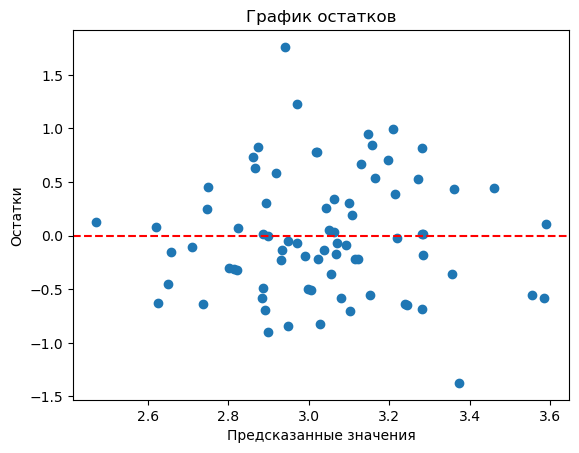

In [34]:
residuals = model_est.resid

plt.scatter(model_est.fittedvalues, residuals)
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.axhline(y=0, color='red', linestyle='--')  
plt.show()

Однако, помимо графического метода, существуют и более формальные статистические тесты на гомоскедастичность, такие как тест тест Уайта. Тест Уайта возвращает p-значения для проверки гипотезы о гомоскедастичности. Если p-значения больше выбранного уровня значимости (0.05), это может указывать на отсутствие оснований отклонять гипотезу о гомоскедастичности.

#### Тест Уайта

In [36]:
het_test = sms.het_white(model_est.resid, model_est.model.exog)
print(het_test)

(12.685813773536852, 0.8904537879406804, 0.552293057721809, 0.9281790254403073)


Результат теста Уайта на гомоскедастичность представлен четырьмя значениями:

LM-статистика (Lagrange Multiplier statistic): Это статистика, используемая для проверки наличия гетероскедастичности в остатках модели. Чем выше значение LM-статистики, тем больше вероятность, что гетероскедастичность присутствует.

p-value для LM-статистики: Это вероятность получить такие или еще более экстремальные значения статистики, при условии, что гомоскедастичность фактически присутствует в данных. Если это значение меньше выбранного уровня значимости (0.05), то есть основания отклонить гипотезу о гомоскедастичности.

F-статистика (F-statistic): Эта статистика используется для тестирования гипотезы о гомоскедастичности.

p-value для F-статистики: Значение p-value для F-статистики также означает вероятность получить такие или еще более экстремальные значения статистики F, при условии, что гомоскедастичность фактически присутствует в данных.

В нашем случае, гипотеза об отсутствии гетероскедастичности при уровне значимости 0,05 не отвергается.

#### Тест Бройша-Пагана

In [40]:
sms.het_breuschpagan(model_est.resid, model.exog)

(2.946146719758335, 0.7082882774648571, 0.5649305413217498, 0.7265177678759305)

Второе число p > 5%, гипотеза об отсутствии гетероскедастичности при уровне значимости 0,05 не отвергается.

Значит у нас гомоскедастичность

#### Ковариационная матрица Вайлда

Тесты Вальда полезны , когда нужно рассмотреть связь нескольких предикторов с результатом вместе и проверить стоит ли какие-то независимые переменные использовать совместно в модели.

Н0 гипотеза о совместной незначимости и при p<5 гипотеза не принимается

In [45]:
vcov_white = model_est1.get_robustcov_results(cov_type = 'HC3').cov_params()
model_est1.wald_test('G_EXP=0, Unemployment=0', scalar=True, cov_p=vcov_white)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=2.6216041071560956, p=0.07991649532431944, df_denom=69, df_num=2>

In [46]:
vcov_white = model_est1.get_robustcov_results(cov_type = 'HC3').cov_params()
model_est1.wald_test('Income_growth=0, Unemployment=0', scalar=True, cov_p=vcov_white)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=4.278843453117502, p=0.017710726239155743, df_denom=69, df_num=2>

In [47]:
vcov_white = model_est1.get_robustcov_results(cov_type = 'HC3').cov_params()
model_est1.wald_test('Unemployment=0, GRP_Growth=0', scalar=True, cov_p=vcov_white)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=3.387519914086665, p=0.03950396167508302, df_denom=69, df_num=2>

In [48]:
vcov_white = model_est1.get_robustcov_results(cov_type = 'HC3').cov_params()
model_est1.wald_test('Unemployment=0, Inf_18=0', scalar=True, cov_p=vcov_white)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=2.619217748745435, p=0.08009393883504096, df_denom=69, df_num=2>

In [49]:
model_est1.f_test('Inf_20 = 0, Inf_18 = 0, Ind_Production_growth=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.6641124878067375, p=0.5769375804179082, df_denom=69, df_num=3>

#### Проверяем конечную модель на правильность спецификации модели (Тест Рамсея)

In [51]:
import statsmodels.stats.outliers_influence as oi
oi.reset_ramsey (model_est, degree = 3)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.1341531460539063, p=0.32761707304807186, df_denom=69, df_num=2>

При уровне значимости 0,05 гипотеза о правильной спецификации модели не отвергается. Значит у нас правильная спецификация модели.

Если p<5%, то неправильная спецификция модели линейной регрессии, наличие пропущенных переменных

## Другие типы модели
В этом проекте качестве основных моделей были рассмотрены 3 типа моделей: 
lin-lin, log-log и log-lin.
Выше была подробно разобрана модель lin-lin с проведением всех тестов. Однако, можно также рассмотреть другие модели и провести такие же тесты с ними, но ниже будут приведены только оценки моделей без проведения тестов, так как они проводятся аналогичным образом. 

### Логарифмическо-линейная регрессия
Изменение какой-либо независмой переменной на 1 (единицу) изменяет зависимую переменную на b*100%, где b - коэффициент при этой независимой переменной

In [57]:
model11 = smf.ols("np.log(Inf_19) ~ GRP_Growth + Unemployment + Inf_20 + Inf_18 + Income_growth + G_EXP", data=data)
model_est11 = model11.fit()
model_est11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Inf_19)   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.077
Date:                Mon, 02 Sep 2024   Prob (F-statistic):             0.0669
Time:                        13:28:13   Log-Likelihood:                 21.126
No. Observations:                  77   AIC:                            -28.25
Df Residuals:                      70   BIC:                            -11.84
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0489      0.223      4.704      0.000       0.604       1.494
GRP_Growth       -0.0066      0.005     -1.294      0.200      -0.017       0.004
Unemployment      0.0303      0.011      2.678      0.009       0.008       0.053
Inf_20           -0.0422      0.032     -1.338      0.185      -0.105       0.021
Inf_18            0.0291      0.041      0.712      0.479      -0.052       0.111
Income_growth    -0.0288      0.016     -1.795      0.077      -0.061       0.003
G_EXP          2.801e-07   2.12e-07      1.319      0.192   -1.43e-07    7.04e-07
==============================================================================
Omnibus:                        0.006   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.997   Jarque-Bera (JB):                0.110
Skew:                           0.018   Prob(JB):                        0.947
Kurtosis:                       2.818   Cond. No.                     1.70e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Линейная в логарифмах
Изменение какой-либо независмой переменной на 1% изменяет зависимую переменную на b%, где b - коэффициент при этой независимой переменной

In [90]:
# model12 = smf.ols("np.log(Inf_19) ~ np.log(GRP_Growth) + np.log(Unemployment) + np.log(Inf_20) + np.log(Inf_18) + np.log(Ind_Production_growth) + np.log(Income_growth)", data=data)
# model_est12 = model12.fit()
# model_est12.summary()